# Use Convolutional Neural Network to Identify Spiral Arms

---
__Motivation__: my astrophysical research in the past three years focused on understanding the origin of spiral arms. Our solar system and the only home that we know reside on a spiral arm of the Milky Way galaxy. My astro work looks back in time and captures spiral arms in their earliest stage of formation. 

How do we know if a galaxy has spiral arms?  The definition of spirals arms is unfortunately visual and subject to  human being's perceptions. Detecting the existence of spiral arms in galaxies is not that much different from detecting cats in social media images.  Machine learning algorithms should help
us find and identify spiral galaxies automatically among millions of astronomical images. Astronomers are beginning  to  use ML for galaxy morphology classification, with varying degrees of successes depending on the specific problem.

Here is my first attempt of building a vanilla CNN using Tensorflow to address the simple question of spiral or non-spiral.  The ultimate goal is to find a model (and dataset) that can offer second opinions and fast-track spiral structure detection in distant galaxies.

Preparing good training and testing datasets is where the domain knowledge about galaxies help greatly. As I only care about 
spiral structures, I construct 3 classes (spiral, non-spiral-early-type, non-spiral-other-types) from the raw dataset provided on Kaggle. 

For  descriptions about the dataset, see group_data.ipynb.   This notebook describes the architecture and model performances. I am going to experiment with models trained with different datasets, so see model*.ipynb for  outcomes of different experiments.

---
The most helpful courses that I have taken on machine learning are Andrew Ng's courses on coursera. Here 
is a link to his course on CNN:
https://www.coursera.org/learn/convolutional-neural-networks

In [55]:
# Run this script to  make gif files out of random traininng images
# !python make_anime.py

### Here is an animation showing the 3 classes of galaxies we are trying to identify:
<table><tr>
<td><img src="./files/spiral_brew.gif" alt="Drawing" width="300" align="left"/> <\td>
<td><img src="./files/early_brew.gif" alt="Drawing" width="300"/><\td>
<td><img src="./files/disk_nonspiral_brew.gif" alt="Drawing" width="300" /><\td>
</tr></table>

## Building a CNN model from scratch 

### Importing the libraries

In [1]:
import keras

In [2]:
print(keras.__version__)

2.4.3


In [3]:
import tensorflow as tf
from keras.preprocessing.image import ImageDataGenerator, img_to_array
print(tf.__version__)

2.4.0


## Data Preprocessing
### Preprocessing the Training set

In [4]:
# customised image sizes
szx = 256
szy = 256
szz = 3

import cv2
def random_input(img):
    shape = img.shape[:2]
    left = int(shape[0]/4)
    top = int(shape[1]/4)
    img = img[left:left*3,top:top*3,:]
    image = cv2.resize(img, shape, interpolation = cv2.INTER_CUBIC)
    image = img_to_array(image)
    return image

In [5]:
#  Image Augmentation and generator
train_datagen = ImageDataGenerator(rescale=1./255,
                                   shear_range=0.25,
                                   zoom_range=0.25,
                                   rotation_range=170,
                                   horizontal_flip=True,
                                   vertical_flip=True,
                                   width_shift_range=0.01,
                                   height_shift_range=0.01,
                                   fill_mode='nearest',
                                   preprocessing_function=random_input)

training_set = train_datagen.flow_from_directory('dataset/training',
                                                 target_size=(szx, szy),
                                                 batch_size=36,
                                                 shuffle=False,
                                                 seed=123,
                                                 subset='training',
                                                 class_mode='categorical')
STEP_SIZE_TRAIN = training_set.n // training_set.batch_size

Found 18290 images belonging to 3 classes.


In [6]:
print(type(training_set))
print(STEP_SIZE_TRAIN)

<class 'tensorflow.python.keras.preprocessing.image.DirectoryIterator'>
508


### Preprocessing the Validation set

In [7]:
valid_datagen = ImageDataGenerator(rescale=1./255,
                                   validation_split=0.15, preprocessing_function=random_input)

valid_set = valid_datagen.flow_from_directory('dataset/training',
                                              target_size=(szx, szy),
                                              batch_size=32,
                                              subset='validation',
                                              shuffle=False,
                                              seed=123,
                                              class_mode='categorical')
STEP_SIZE_VALID = valid_set.n // valid_set.batch_size

Found 2742 images belonging to 3 classes.


In [8]:
print(type(valid_set))
print(STEP_SIZE_VALID)

<class 'tensorflow.python.keras.preprocessing.image.DirectoryIterator'>
85


### Visualise a random training image

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


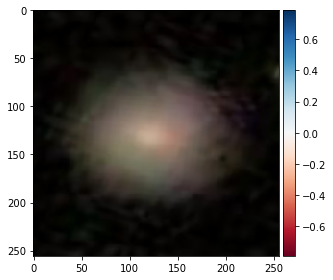

{'disk_nonspirals': 0, 'early_types': 1, 'spirals': 2}
[1. 0. 0.]


In [9]:
from skimage import io

def imshow(image_RGB):
    io.imshow(image_RGB) 
    io.show()

x, y = training_set.next()
image = x[1]
imshow(image)
print(training_set.class_indices)
print(y[1])

## Building the CNN

### Initialising the CNN

In [10]:
cnn = tf.keras.models.Sequential()

### Convolution

In [11]:
# layer 1
cnn.add(tf.keras.layers.Conv2D(filters=16, kernel_size=3, activation='relu', input_shape=[szx, szy, szz]))

### Pooling

In [12]:
cnn.add(tf.keras.layers.MaxPool2D(pool_size=2, strides=2))

### Adding a few more convolution + pooling layers

In [13]:
# layer 2
cnn.add(tf.keras.layers.Conv2D(filters=64, kernel_size=3, activation='relu'))
cnn.add(tf.keras.layers.MaxPool2D(pool_size=2))

# layer 3
cnn.add(tf.keras.layers.Conv2D(filters=64, kernel_size=3, activation='relu'))
cnn.add(tf.keras.layers.MaxPool2D(pool_size=2))

# layer 4
cnn.add(tf.keras.layers.Conv2D(filters=128, kernel_size=3, activation='relu'))
cnn.add(tf.keras.layers.MaxPool2D(pool_size=2))

# layer 5
cnn.add(tf.keras.layers.Conv2D(filters=128, kernel_size=3, activation='relu'))
cnn.add(tf.keras.layers.MaxPool2D(pool_size=2))

### Flattening

In [14]:
cnn.add(tf.keras.layers.Flatten())

### Full Connection

In [15]:
cnn.add(tf.keras.layers.Dense(units=512, activation='relu'))

### A Dropout regularization to prevent overfitting

In [16]:
cnn.add(tf.keras.layers.Dropout(0.3))

In [17]:
cnn.add(tf.keras.layers.Dense(units=512, activation='relu'))
cnn.add(tf.keras.layers.Dropout(0.3))
cnn.add(tf.keras.layers.Dense(units=512, activation='relu'))
cnn.add(tf.keras.layers.Dropout(0.3))

### Output Layer

In [18]:
cnn.add(tf.keras.layers.Dense(units=3, activation='softmax'))

## Training the CNN

### Compiling the CNN

In [19]:
cnn.compile(optimizer=keras.optimizers.Adam(lr=0.8e-4), 
            loss = 'categorical_crossentropy', 
            metrics = ['accuracy'])

In [20]:
print(cnn.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 254, 254, 16)      448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 127, 127, 16)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 125, 125, 64)      9280      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 62, 62, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 60, 60, 64)        36928     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 30, 30, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 28, 28, 128)       7

### Training the CNN on the Training set and evaluating it on the Test set

In [21]:
# from tensorflow import keras
import numpy as np
from IPython.display import clear_output
import matplotlib.pyplot as plt
%config InlineBackend.figure_format = 'retina'

#### Visualise training and validation accuracy vs epochs
* code block adapted from https://github.com/kapil-varshney/utilities/blob/master/training_plot/training_plot_ex_with_cifar10.ipynb

In [22]:
class TrainingPlot(keras.callbacks.Callback):
    
    # This function is called when the training begins
    def on_train_begin(self, logs={}):
        # Initialize the lists for holding the logs, losses and accuracies
        self.losses = []
        self.acc = []
        self.val_losses = []
        self.val_acc = []
        self.logs = []
    
    # This function is called at the end of each epoch
    def on_epoch_end(self, epoch, logs={}):
        
        # Append the logs, losses and accuracies to the lists
        self.logs.append(logs)
        self.losses.append(logs.get('loss'))
        self.acc.append(logs.get('accuracy'))
        self.val_losses.append(logs.get('val_loss'))
        self.val_acc.append(logs.get('val_accuracy'))
        
        # Before plotting ensure at least 2 epochs have passed
        if len(self.losses) > 1:
            
            # Clear the previous plot
            clear_output(wait=True)
            N = np.arange(0, len(self.losses))
            
            # You can chose the style of your preference
            # print(plt.style.available) to see the available options
            plt.style.use("seaborn-talk")
            
            # Plot train loss, train acc, val loss and val acc against epochs passed
            plt.figure()
            plt.plot(N, self.losses, linestyle=':', label = "train_loss")
            plt.plot(N, self.acc, linestyle=':', label = "train_accuracy")
            plt.plot(N, self.val_losses, label = "val_loss")
            plt.plot(N, self.val_acc, label = "val_accuracy")
            plt.title("Training Loss and Accuracy [Epoch {}]".format(epoch))
            plt.xlabel("Epoch #")
            plt.ylabel("Loss/Accuracy")
            plt.legend()
            plt.show()
plot_losses = TrainingPlot()

In [23]:
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, CSVLogger
import os
checkpointer = ModelCheckpoint(
    filepath  = os.environ['HOME'] + '/work/learn_py/self/astro/dataset/wts_cnn_model_best.h5', verbose=2, save_best_only=True)

early_stopping = EarlyStopping(
    monitor = 'val_loss', patience=10, verbose=1, mode='auto')

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2,
                              patience=4)

csv_logger = CSVLogger(os.environ['HOME'] + '/work/learn_py/self/astro/dataset/train_cnn_model_best.csv')

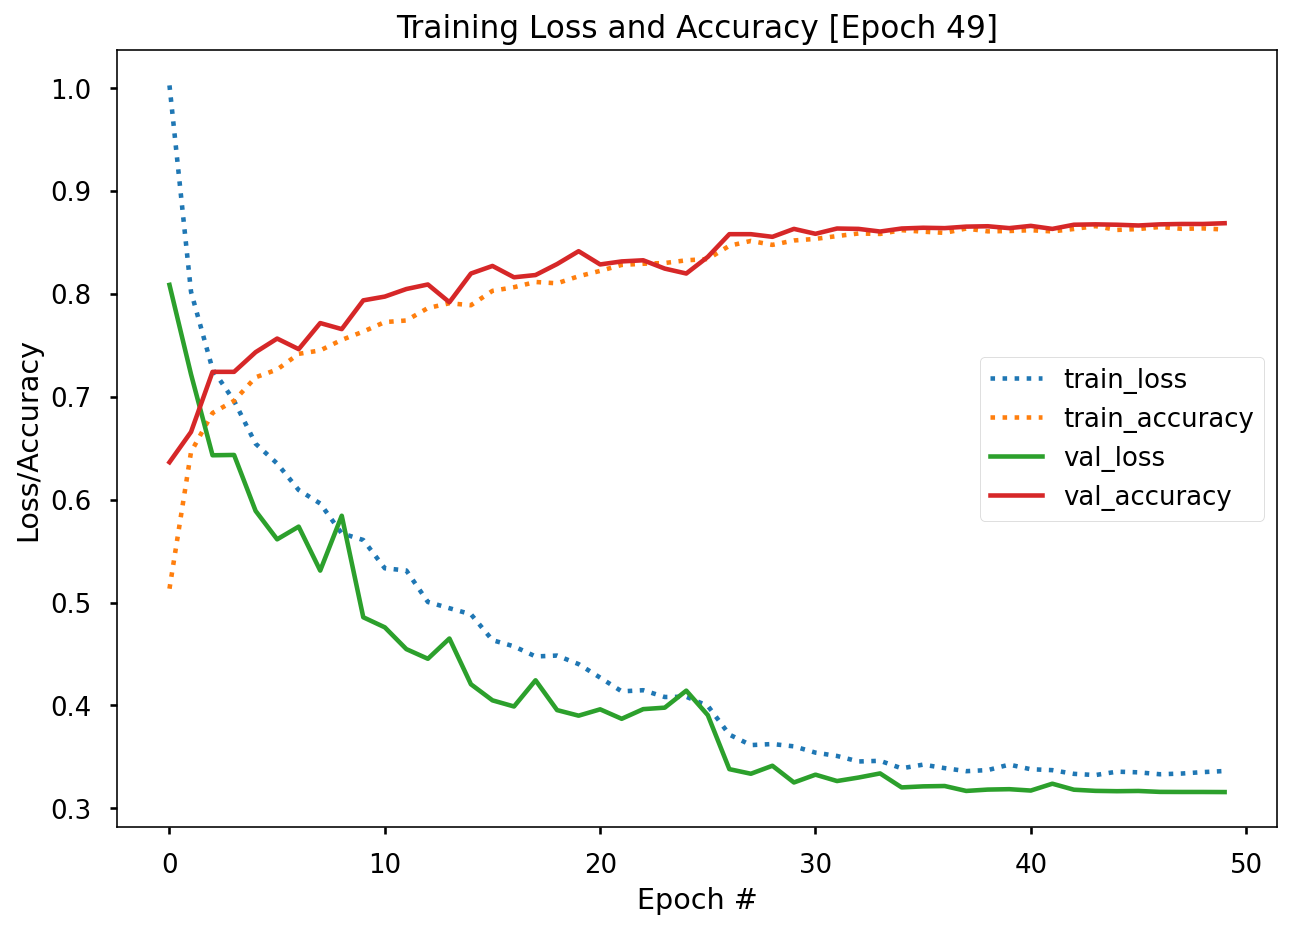


Epoch 00050: val_loss improved from 0.31583 to 0.31575, saving model to /Users/tiantianyuan/work/learn_py/self/astro/dataset/wts_cnn_model_best.h5
CNN running time is 485.96mins


In [24]:
import time
t1 = time.time()
results = cnn.fit(x=training_set, validation_data=valid_set,
                  steps_per_epoch=STEP_SIZE_TRAIN,
                  validation_steps=STEP_SIZE_VALID,
                  epochs=50, callbacks=[plot_losses, checkpointer, early_stopping, reduce_lr, csv_logger])
t2 = time.time()
print('CNN running time is {:.2f}mins'.format((t2 - t1)/60))

### Save models

In [25]:
# Save the entire model as a SavedModel.
# !mkdir -p saved_model
cnn.save('saved_model/cnn_spiral_model_bestv0')
cnn.save('saved_model/cnn_spiral_model_bestv0.h5')

INFO:tensorflow:Assets written to: saved_model/cnn_spiral_model_bestv4/assets


### Model evaluation using Confusion Matrix and F1 score

In [40]:
from keras.models import Model,load_model
model_check = load_model('saved_model/cnn_spiral_model_bestv0.h5')

In [48]:
test_datagen = ImageDataGenerator(rescale=1./255, preprocessing_function=random_input)
test_set = test_datagen.flow_from_directory('dataset/test',
                                            target_size=(szx, szy),
                                            batch_size=100,
                                            shuffle=False,
                                            class_mode='categorical')

test_set.reset()

Y_pred = model_check.predict(
                            test_set,
                            steps=test_set.n / test_set.batch_size,
                            verbose=1)

y_pred = np.argmax(Y_pred, axis=1)

Found 2979 images belonging to 3 classes.
29/29 [==============================] - 23s 747ms/step


In [28]:
from sklearn.metrics import classification_report, confusion_matrix

cm=confusion_matrix(test_set.classes, y_pred)

print('The confusion matrix is \n{}\n'.format(cm))

f1 = classification_report(test_set.classes, y_pred, target_names=training_set.class_indices)
print('F1 score:{}\n'.format(f1))

The confusion matrix is 
[[654 137 190]
 [ 35 963   1]
 [ 73   1 925]]

F1 score:                 precision    recall  f1-score   support

disk_nonspirals       0.86      0.67      0.75       981
    early_types       0.87      0.96      0.92       999
        spirals       0.83      0.93      0.87       999

       accuracy                           0.85      2979
      macro avg       0.85      0.85      0.85      2979
   weighted avg       0.85      0.85      0.85      2979




### Conclusion:
This vanilla CNN model does a good job (see the classification report above). 
It is not overfitting. An accuracy of 0.85 is not amazing either. 
Two directions to investigate next: 
1. Experiment  with other state-of-the art deep CNN model using transfer learning.  Would those models give 'amazing' results? We shall see. 
2. Whether the limit lies in the data themselves. as the 'ground truth' of image labels are not usually robust.

##  Testing the CNN's performance on individual new images
What would the model predict for images that are very different from its training, validation, and testing sets? 

### We are going to have fun with:   
1. A very well-known nearby large spiral galaxy with beautiful rgb color. 
2. A nearby spiral galaxy from a single-band color.
3. An ancient spiral galaxy (2.6 years after the Big Bang) that is gravitationally lensed.
4. A very distant 'cosmic ring of fire' galaxy
5. Some clumpy high-z galaxies
6. Some nearby and distant early-type (roundish) galaxies.

In [49]:
# check which label is which
training_set.class_indices

{'disk_nonspirals': 0, 'early_types': 1, 'spirals': 2}

In [42]:
from keras.preprocessing import image
def image_in(fileloc, dimx=szx, dimy=szy):
    """ reshape a raw jpg image into an array that is acceptable by keras models.
    Parameters
    ----------
    fileloc : path and name for the input image
        an input directory under which files are searched.
    dimx, dimy : int
        should be the same as the target_size in the trained CNN
    ----------
    Return
    test_image that can be processed by kera models 
    """
    test_image = image.load_img(fileloc, target_size = (dimx, dimy))
    test_image = image.img_to_array(test_image)
    test_image = np.expand_dims(test_image, axis = 0)
    return test_image

### Prediction 1. 
This is a beautiful nearby spiral galaxy M101. The image is much large and has more details than the training set. 
Would CNN be able to recognise it as as spiral galaxy ?  Let's see.
<div>
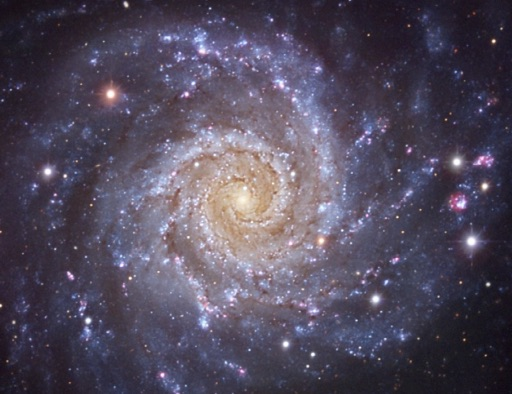
</div>


In [50]:
import numpy as np
model_check = load_model('saved_model/cnn_spiral_model_bestv0.h5')
fileloc = 'dataset/single_prediction_test/nearby_large.jpg'
image_pred = image_in(fileloc)
result = model_check.predict(image_pred)

print('The predicted label is ', result)

if result[0][2] >= 0.5:
    prediction = 'a spiral galaxy'
elif result[0][1] >= 0.5:
    prediction = 'not a spiral galaxy but an elliptical galaxy'
elif result[0][0] >= 0.5:
    prediction = 'a disk without obvious spiral structures'

print('CNN predicts that the image above is ', prediction)   

The predicted label is  [[0. 0. 1.]]
CNN predicts that the image above is  a spiral galaxy


### Prediction 2.  
This is also a nearby spiral galaxy. The image is taken using only one filter,  i.e., a single color image.
Would CNN trained on 3-color images be able to recognise it as as spiral galaxy ?  Let's see.

<div>
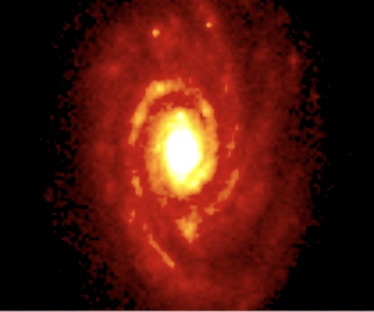
</div>


In [51]:
fileloc = 'dataset/single_prediction_test/spiral_singleband.jpg'
image_pred = image_in(fileloc)
result = model_check.predict(image_pred)

print(result)

if result[0][2] >= 0.5:
    prediction = 'a spiral galaxy'
elif result[0][1] >= 0.5:
    prediction = 'not a spiral galaxy but an elliptical galaxy'
elif result[0][0] >= 0.5:
    prediction = 'a disk without obvious spiral structures'

print('CNN predicts that the image above is ', prediction)   

[[1. 0. 0.]]
CNN predicts that the image above is  a disk without obvious spiral structures


### Prediction 3. 

This is an ancient spiral galaxy that I studied. Would the CNN trained using 
nearby spiral galaxies be able to identify such a proto-type spiral galaxy ? 
https://en.wikipedia.org/wiki/A1689B11

<div>
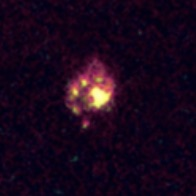
</div>


In [52]:
fileloc = 'dataset/single_prediction_test/ancient_spiral_A1689B11.jpg'
image_pred = image_in(fileloc)
result = model_check.predict(image_pred)

print(result)
if result[0][2] >= 0.5:
    prediction = 'a spiral galaxy'
elif result[0][1] >= 0.5:
    prediction = 'not a spiral galaxy but an elliptical galaxy'
elif result[0][0] >= 0.5:
    prediction = 'a disk without obvious spiral structures'

print('CNN predicts that the image above is ', prediction)   

[[0. 0. 1.]]
CNN predicts that the image above is  a spiral galaxy


### Prediction 4:  What about a weird type ? Spiral or non-Spiral ?
This is the cosmic 'ring of fire' galaxy that I discovered. 
https://astronomycommunity.nature.com/posts/a-distant-giant-with-a-ring-on-it

Would the CNN trained using nearby spiral galaxies classify such a ring galaxy as 'spiral' or 'nonspiral'?  I am curious.  Let's see! 
<div>
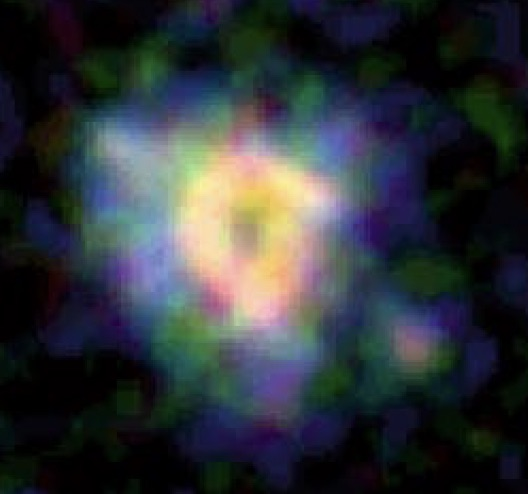
</div>



In [53]:
fileloc = 'dataset/single_prediction_test/cosmic_ring_of_fire.jpg'
image_pred = image_in(fileloc)
result = model_check.predict(image_pred)

if result[0][2] >= 0.5:
    prediction = 'a spiral galaxy'
elif result[0][1] >= 0.5:
    prediction = 'not a spiral galaxy but an elliptical galaxy'
elif result[0][0] >= 0.5:
    prediction = 'a disk without obvious spiral structures'
print('CNN predicts that the image above is ', prediction)   

CNN predicts that the image above is  a spiral galaxy


### Prediction 5-8:  What about some clumpy high-redshift galaxies and ellipitcals like these ? 
Images from the CANDELS survey and other publically available images:
<div>
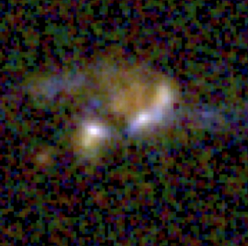
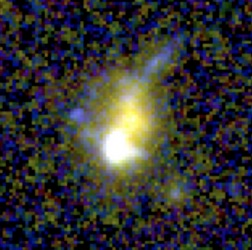
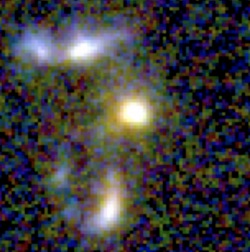
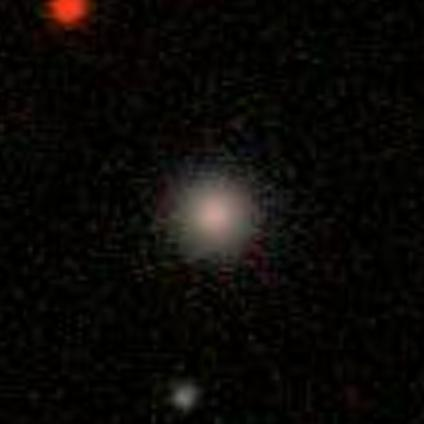
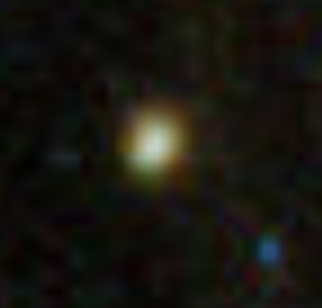


In [54]:
fileloc = 'dataset/single_prediction_test/clumpy1.jpg'
image_pred = image_in(fileloc)

result = model_check.predict(image_pred)
if result[0][2] >= 0.5:
    prediction = 'a spiral galaxy'
elif result[0][1] >= 0.5:
    prediction = 'not a spiral galaxy but an elliptical galaxy'
elif result[0][0] >= 0.5:
    prediction = 'a disk without obvious spiral structures'

print(result)
print('CNN predicts that clumpy1 is ', prediction)  

fileloc = 'dataset/single_prediction_test/clumpy2.jpg'
image_pred = image_in(fileloc)
result = model_check.predict(image_pred)
if result[0][2] >= 0.5:
    prediction = 'a spiral galaxy'
elif result[0][1] >= 0.5:
    prediction = 'not a spiral galaxy but an elliptical galaxy'
elif result[0][0] >= 0.5:
    prediction = 'a disk without obvious spiral structures'
print(result)
print('CNN predicts that clumpy2 is ', prediction)   

fileloc = 'dataset/single_prediction_test/clumpy3.jpg'
image_pred = image_in(fileloc)
result = model_check.predict(image_pred)

if result[0][2] >= 0.5:
    prediction = 'a spiral galaxy'
elif result[0][1] >= 0.5:
    prediction = 'not a spiral galaxy but an elliptical galaxy'
elif result[0][0] >= 0.5:
    prediction = 'a disk without obvious spiral structures'

print(result)

print('CNN predicts that clumpy3 is ', prediction)  

fileloc = 'dataset/single_prediction_test/low-z_early1.jpg'
image_pred = image_in(fileloc)
result = model_check.predict(image_pred)
print(result)

if result[0][2] >= 0.5:
    prediction = 'a spiral galaxy'
elif result[0][1] >= 0.5:
    prediction = 'not a spiral galaxy but an elliptical galaxy'
elif result[0][0] >= 0.5:
    prediction = 'a disk without obvious spiral structures'

print('CNN predicts that low-z_early1 is ', prediction)   

fileloc = 'dataset/single_prediction_test/high-z_early1.jpg'
image_pred = image_in(fileloc)
result = model_check.predict(image_pred)
if result[0][2] >= 0.5:
    prediction = 'a spiral galaxy'
elif result[0][1] >= 0.5:
    prediction = 'not a spiral galaxy but an elliptical galaxy'
elif result[0][0] >= 0.5:
    prediction = 'a disk without obvious spiral structures'
print(result)
    
print('CNN predicts that high-z_early1 is ', prediction)   

[[0. 0. 1.]]
CNN predicts that clumpy1 is  a spiral galaxy
[[0. 0. 1.]]
CNN predicts that clumpy2 is  a spiral galaxy
[[1. 0. 0.]]
CNN predicts that clumpy3 is  a disk without obvious spiral structures
[[0. 1. 0.]]
CNN predicts that low-z_early1 is  not a spiral galaxy but an elliptical galaxy
[[1. 0. 0.]]
CNN predicts that high-z_early1 is  a disk without obvious spiral structures


### Comment